# Mean-Variance Portfolio Optimization with a Risk-Free Asset
Implements the Capital Market Line (CML) and tangency portfolio computation.

**Source:** Essentials of Financial Economics  
**Authors:** Michael Donadelli, Michele Costola, Ivan Gufler  
**Date:** May 8, 2025

## 0. Preliminaries

In this code we implement Markowitz's Mean-Variance approach for optimal portfolios in an economy with N=5 risky assets and one riskless security. The goal is to find the allocation of N+1 assets that deliver an expected return $\mu_p$ with less risk as possible.

Formally, our problem is:

$$
\min_w \frac{1}{2} \mathbf{w}^\prime \Sigma \mathbf{w} \quad \text{s.t.} \quad \mathbf{w}^\prime \mathbf{1} + \mathbf{w}_f = 1 \quad \text{and}  \quad \mu_p = \mathbf{w}^\prime \boldsymbol{\mu} + \mathbf{w}_f r_f
$$

We can simplyfy the problem by expressing the first constraint as $w_f = 1 - w^\prime \mathbf{1}$ and substituting in the second. The lagrangian of the problem can be written as: 

$$
\mathcal{L} = \left( \frac{1}{2} \right) 
\mathbf{w}'\Sigma\mathbf{w} 
+ \lambda \left[ \mu_p - \mathbf{w}'\boldsymbol{\mu} - (1 - \mathbf{w}'\mathbf{1})r_f \right]
$$
The solution is found by taking the derivatives of $\mathcal{L}$ w.r.t. $w$ and $\lambda$:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \Sigma \mathbf{w} - \lambda \boldsymbol{\mu} + \lambda \mathbf{1} r_f = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} =  \mu_p - \mathbf{w}'\boldsymbol{\mu} - (1 - \mathbf{w}'\mathbf{1})r_f= 0
$$

From the first equation we solve for $\mathbf{w}$:
$$
\mathbf{w} = \lambda \Sigma^{-1} (\mu - \mathbf{1} r_f)
$$

Substituting in the second equation $\mu_p = r_f + \mathbf{w}'(\boldsymbol{\mu} - \mathbf{1}r_f)$:

$$
 \mu_p =rf +  \lambda (\boldsymbol{\mu} - \mathbf{1} rf)^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} rf)
$$

Solving for $\lambda$:
$$
\lambda = \frac{\mu_p - rf}{(\boldsymbol{\mu} - \mathbf{1} rf)^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} rf)}
$$

Define $H=(\boldsymbol{\mu} - \mathbf{1} r_f)^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)$ and notice that the square root $\sqrt{H}$ corresponds to the Sharpe ratio of the risky assets

The optimal weight are computed by substituting back $\lambda$ into $\mathbf{w} = \lambda \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)$:

$$
\mathbf{w} = \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f) \frac{(\mu_p - r_f)}{H}
$$

and

$$
w_f = 1 - \mathbf{w}^\prime \mathbf{1}
$$

Recall that the final objective is to find the portfolio frontier in the $(\sigma, \mu)$ space. Thus, the next step is to compute the variance of the optimal portfolio. By definition: $\sigma^2_p = \mathbf{w}^\prime \Sigma \mathbf{w}$. Subsituting the solution for w:

$$
\sigma^2_p = \mathbf{w}^\prime \Sigma \mathbf{w} = \frac{(\mu_p - \mathbf{1} rf)^2}{H}
$$

Taking the square root of the latter and solving for $\mu_p$ we obtain an equation describing the relationship between risk and return. 

$$
\mu_p = r_f \pm \sqrt{H} \sigma_p
$$
Two aspect are noteworthy:
1. Differently than in the N risky assets case, the frontier is a straight line, with intercept $r_f$
2. The slope of the frontier (or Capital Market Line, CML) is the Sharpe ratio of the risky securities

As before, the upper part of the CML (+) denotes the risk-return attainable by efficient portfolios 

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')

## 2. Load Data
We use returns of the 5 oldest stocks in the DJIA index: Procter and Gamble, 3M, Merkx, IBM and American Express, from February 2000 to December 2022. The risk-free rate is from Fama-French library and proxied by the one-month US Treasury bill. Importantly, the risk-free rate is annualized, while stock returns are at monthly frequency. Hence, we divide it by 12.

After loading the data we compute the average return, a measure of expected returns, and the covariance matrix, which describes the comovement of stocks' returns.

In [47]:
Ret = pd.read_excel('../Data/Returns.xlsx')
Factors = pd.read_excel('../Data/FF_Factors.xlsx')

Rf = np.array(Factors.iloc[1:, 4]) / 1200
R = np.array(Ret.iloc[:, 1:])
N = R.shape[1]

print(Ret.head())


        Date        PG       MMM       IBM       MRK       AXP
0 2000-02-01 -0.128103 -0.058078 -0.084633 -0.217011 -0.184296
1 2000-03-01 -0.354197  0.010757  0.153281  0.009137  0.109921
2 2000-04-01  0.052864 -0.021877 -0.058077  0.124007  0.003777
3 2000-05-01  0.118157 -0.010100 -0.037557  0.073741  0.085480
4 2000-06-01 -0.146617 -0.025797  0.022199  0.030786 -0.034723


## 3. Compute Statistics

We start to construct the efficient frontier by computing $\mu$ as the average stocks' returns and the covariance matrix $\Sigma$

In [48]:
z = np.mean(R, axis=0).reshape(-1, 1)
sig = np.std(R, axis=0)
V = np.cov(R, rowvar=False)
V1 = np.linalg.inv(V)

## 4. Capital Market Line (CML) Parameters

Recall that the efficient frontier in an economy with N risky assets and a riskless security is describe by the Capital Market Line:

$$
\mu_p = r_f \pm \sqrt{H} \sigma_p
$$

and the variance of the optimal portfolio is:
$$
\sigma^2_p = \frac{(\mu_p - r_f)^2}{\underbrace{(\boldsymbol{\mu} - \mathbf{1} r_f)^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)}_{H}}
$$

In [52]:
H = (z - np.mean(Rf)).T @ V1 @ (z - np.mean(Rf))
sqrtH = np.sqrt(H)

mu_p = np.linspace(np.mean(Rf), 0.02, 100)
sig2_p = (1 / H) * (mu_p - np.mean(Rf))**2
sig_p = np.sqrt(sig2_p)

mu_t = np.mean(Rf) + H / (np.ones((1, N)) @ V1 @ (z - np.ones((N, 1)) * np.mean(Rf)))
sig_t = sqrtH / (np.ones((1, N)) @ V1 @ (z - np.ones((N, 1)) * np.mean(Rf)))


## 5. Risky Asset Efficient Frontier

Additionally, we construct the efficient frontier for risky stocks only. To this end we compute the variance of the optimal weight when no risk-free bond is available as: 

$$
\sigma_p^2 = \frac{1}{\Delta} \left( C\mu_p^2 - 2B\mu_p + A \right).
$$

and define target expected returns $\mu_p$ 

In [50]:
A = z.T @ V1 @ z
B = np.ones((1, N)) @ V1 @ z
C = np.ones((1, N)) @ V1 @ np.ones((N, 1))
D = A * C - B**2


mu_p_risky = np.linspace(0.001, 0.009, 100)
sig2_p_risky = (1 / D) * (C * mu_p_risky**2 - 2 * B * mu_p_risky + A)
sig_pp_risky = np.sqrt(sig2_p_risky)
sig_pp_risky = np.where(mu_p_risky < 0.005, np.nan, sig_pp_risky)

## 6. Plot CML and Efficient Frontier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


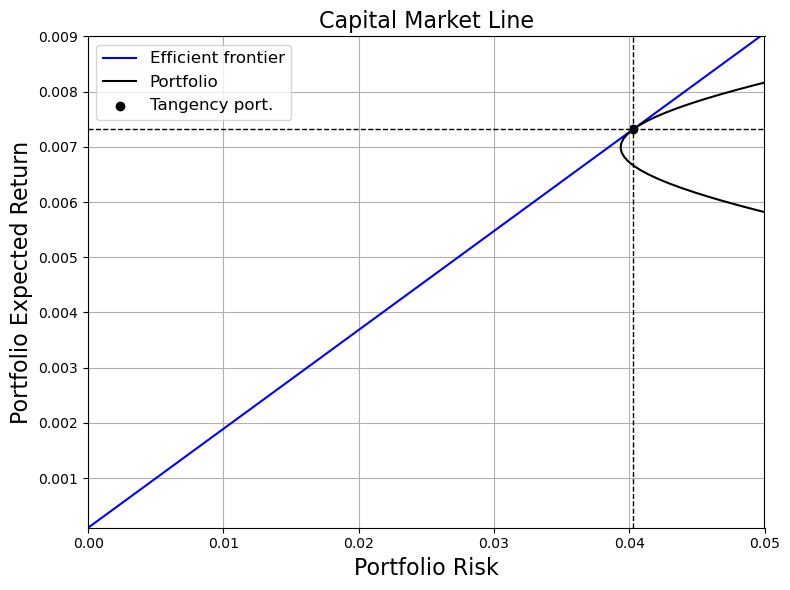

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(sig_p.flatten(), np.mean(Rf) + sqrtH.flatten() * sig_p.flatten(), '-b', linewidth=1.5)
plt.plot(sig_pp_risky.flatten(), mu_p_risky.flatten(), '-k', linewidth=1.5)
plt.scatter(sig_t.flatten(), mu_t.flatten(), marker='o', color='k')

plt.title('Capital Market Line', fontsize=16)
plt.xlabel('Portfolio Risk', fontsize=16)
plt.ylabel('Portfolio Expected Return', fontsize=16)
plt.legend(['Efficient frontier', 'Portfolio', 'Tangency port.', 'Stocks', 'Autoupdate', 'off'], fontsize=12, loc='upper left')
plt.xlim([0, 0.05])
plt.ylim([np.mean(Rf), 0.009])
plt.axhline(mu_t.flatten(), linestyle='--', color='k', linewidth=1)
plt.axvline(sig_t.flatten(), linestyle='--', color='k', linewidth=1)
plt.tight_layout()
plt.grid(True)
plt.savefig('MV_rf.eps', format='eps')
plt.show()

## 7. Compute Optimal Weights

Finally, we compute the optimal weights of the tangency portfolio and for different target expected returns $\mu_p$, up to 5%. The allocation on the risky asset is: $w_f = 1- \mathbf{w}^\prime \mathbf{1}$

We also compute the tangency portfolio, i.e. the point in which the Capital Market Line coincides with the efficient frontier. 

Formally, the tangency portfolio is found by enforcing $\mathbf{w}^\prime \mathbf{1}$ in the solution for the optimal weight $\mathbf{w} = \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f) \frac{(\mu_p - \mathbf{1} r_f)}{H}$. In practice, pre-multiply the latter by $\mathbf{1}^\prime$:

$$
    \underbrace{\mathbf{1}^\prime \mathbf{w}}_{1} = \mathbf{1}^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f) \frac{(\mu_p - r_f)}{H}
$$

Solve for $(\mu_p - r_f)$:

$$
\mu_p - r_f = \frac{H}{\mathbf{1}^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)}
$$
Substitute back in the equation of the optimal weights:

$$
\mathbf{w} = \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f) \frac{1}{H}  \frac{H}{\mathbf{1}^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)}
$$

Simplifying the terms:
$$
\mathbf{w}_T =   \frac{ \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f) }{\mathbf{1}^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} r_f)}
$$

where the expected return and volatility of the tangency portfolio are:
$$ 
\mu_T = rf + \sqrt{H} \sigma_T \\
\sigma_T = \frac{\sqrt{H}}{\mathbf{1}^\prime \Sigma^{-1} (\boldsymbol{\mu} - \mathbf{1} rf)}
$$


In [34]:
mup_target = np.linspace(0.001, 0.05, 10)
wp = V1 @ (z - np.ones((N, 1)) * np.mean(Rf)) @ ((mup_target - np.mean(Rf)) / H)
wT = V1 @ (z - np.ones((N, 1)) * np.mean(Rf)) / (np.ones((1, N)) @ V1 @ (z - np.ones((N, 1)) * np.mean(Rf)))

sum_wT = np.sum(wT)
sum_wp = np.sum(wp, axis=0)
rf_weight_row = np.hstack([1 - sum_wT, 1 - sum_wp]).reshape(1, -1)

## 8. Display and Save Weights

In [35]:
risky_weights_matrix = np.hstack([wT, wp])
weight_data = np.vstack([risky_weights_matrix, rf_weight_row])
weight_data = np.round(weight_data, 3)

columns = ['wT'] + [f'{round(mu * 100, 2)}%' for mu in mup_target]
index = Ret.columns[1:].tolist() + ['Rf']

Weights = pd.DataFrame(weight_data, columns=columns, index=index)

print('Optimal Weights (Tangency and CML):')
display(Weights)

Weights.to_excel('Weights_MVrf.xlsx')

Optimal Weights (Tangency and CML):


,wT,0.1%,0.64%,1.19%,1.73%,2.28%,2.82%,3.37%,3.91%,4.46%,5.0%
PG,0.383,0.879,0.375,-0.130,-0.635,-1.140,-1.644,-2.149,-2.654,-3.158,-3.663
MMM,0.209,0.480,0.204,-0.071,-0.346,-0.621,-0.897,-1.172,-1.447,-1.722,-1.998
IBM,0.391,0.897,0.382,-0.133,-0.648,-1.163,-1.678,-2.193,-2.708,-3.223,-3.738
MRK,0.209,0.478,0.204,-0.071,-0.345,-0.620,-0.895,-1.169,-1.444,-1.718,-1.993
AXP,-0.192,-0.441,-0.188,0.065,0.319,0.572,0.825,1.079,1.332,1.585,1.839
Rf,-0.000,-1.293,0.023,1.339,2.656,3.972,5.288,6.604,7.921,9.237,10.553
